In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nayeem04/breakhist-histopathological-breast-cancer")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/breakhist-histopathological-breast-cancer


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
base = "/kaggle/input/breakhist-histopathological-breast-cancer"
folder = "Breast Cancer"

full_path = os.path.join(base, folder)
print(full_path)

/kaggle/input/breakhist-histopathological-breast-cancer/Breast Cancer


In [8]:
import os
import pandas as pd

DATASET_PATH = "/kaggle/input/breakhist-histopathological-breast-cancer/Breast cancer"

image_records = []

for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)

    if not os.path.isdir(label_path):
        continue

    for file in os.listdir(label_path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            magnification = file.split("-")[-2] if "-" in file else None
            image_records.append({
                "label": label_folder,
                "magnification": magnification,
                "path": os.path.join(label_path, file)
            })

df = pd.DataFrame(image_records)
df.head()


,label,magnification,path
0,Breast Cancer Benign,40,/kaggle/input/breakhist-histopathological-brea...
1,Breast Cancer Benign,40,/kaggle/input/breakhist-histopathological-brea...
2,Breast Cancer Benign,100,/kaggle/input/breakhist-histopathological-brea...
3,Breast Cancer Benign,400,/kaggle/input/breakhist-histopathological-brea...
4,Breast Cancer Benign,100,/kaggle/input/breakhist-histopathological-brea...


In [9]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          4800 non-null   object
 1   magnification  4800 non-null   object
 2   path           4800 non-null   object
dtypes: object(3)
memory usage: 112.6+ KB


(None,
                        label magnification  \
 count                   4800          4800   
 unique                     2             4   
 top     Breast Cancer Benign           100   
 freq                    2400          1407   
 
                                                      path  
 count                                                4800  
 unique                                               4800  
 top     /kaggle/input/breakhist-histopathological-brea...  
 freq                                                    1  )

In [10]:
df["label"].value_counts()

label
Breast Cancer Benign       2400
Breast Cancer Malignant    2400
Name: count, dtype: int64

In [12]:
df["magnification"].value_counts()

magnification
100    1407
200    1389
400    1379
40      625
Name: count, dtype: int64

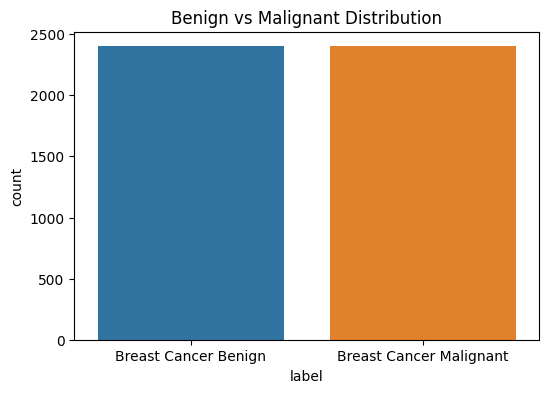

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Benign vs Malignant Distribution")
plt.show()

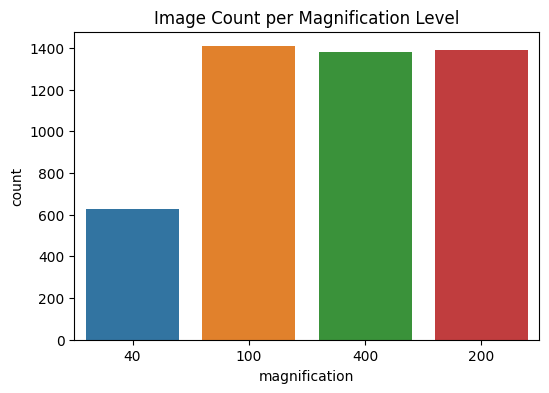

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="magnification")
plt.title("Image Count per Magnification Level")
plt.show()


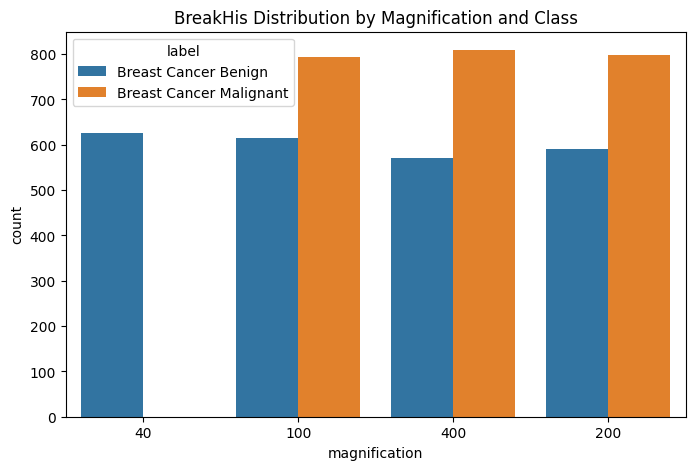

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="magnification", hue="label")
plt.title("BreakHis Distribution by Magnification and Class")
plt.show()

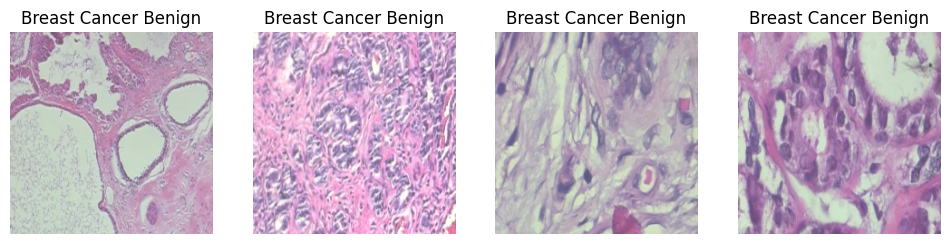

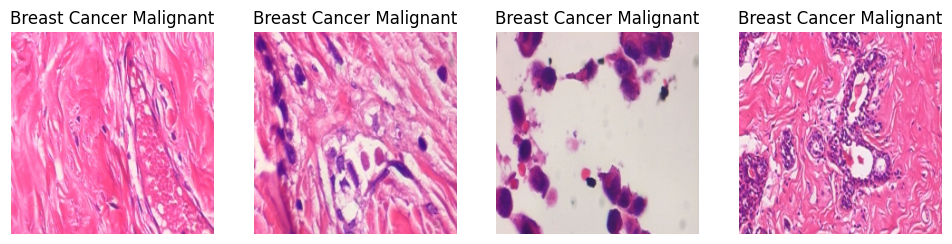

In [20]:
def show_samples(label, n=4):
    subset = df[df["label"] == label]
    
    if len(subset) == 0:
        print(f"No images found for label: {label}")
        return
    
    n = min(n, len(subset))  
    sample_paths = subset.sample(n)["path"].values

    plt.figure(figsize=(12,3))
    for i, path in enumerate(sample_paths, 1):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.show()


show_samples("Breast Cancer Benign")
show_samples("Breast Cancer Malignant")


In [21]:
sizes = []
for p in df["path"].sample(200):
    img = cv2.imread(p)
    sizes.append(img.shape)

pd.Series(sizes).value_counts()

(224, 224, 3)    200
Name: count, dtype: int64

In [25]:
!pip install opencv-python tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 92.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [27]:
def kmeans_segmentation(image, k=3):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_vals = img.reshape((-1, 3))
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
    _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape(img.shape)
    return segmented_image

In [28]:
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg")

def extract_features(image):
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = resnet.predict(image, verbose=0)
    return features.flatten()


I0000 00:00:1763360927.199827      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763360927.200451      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
from tqdm import tqdm

DATASET_PATH = "/kaggle/input/breakhist-histopathological-breast-cancer/Breast cancer"

X = []
y = []


for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path):
        continue

    for file in tqdm(os.listdir(label_path), desc=f"Processing {label_folder}"):
        if file.lower().endswith((".png",".jpg",".jpeg")):
            path = os.path.join(label_path, file)
            img = cv2.imread(path)

            # segmentation
            segmented = kmeans_segmentation(img, k=3)

            # feature extraction
            feat = extract_features(segmented)
            X.append(feat)
            y.append(label_folder)


Processing Breast Cancer Malignant: 100%|██████████| 2400/2400 [11:04<00:00,  3.61it/s]


In [33]:
X = np.array(X)
y = pd.Series(y).str.upper().replace({
    "BREAST CANCER BENIGN": "BENIGN",
    "BREAST CANCER MALIGNANT": "MALIGNANT"
})

In [34]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

svm = SVC(kernel="linear")

n_features_to_select = 200
step = 50

current_features = X
remaining = current_features.shape[1]
num_iterations = (remaining - n_features_to_select) // step

progress = tqdm(total=num_iterations, desc="RFE Feature Selection")

while remaining > n_features_to_select:
    selector = RFE(estimator=svm, n_features_to_select=max(n_features_to_select, remaining - step), step=step)
    current_features = selector.fit_transform(current_features, y_enc)

    remaining = current_features.shape[1]
    progress.update(1)

progress.close()
X_selected = current_features
print("Final feature shape:", X_selected.shape)

RFE Feature Selection: 37it [03:59,  6.47s/it]                        

Final feature shape: (4800, 200)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

In [44]:
svm_final = SVC(kernel="linear", probability=True)
svm_final.fit(X_train, y_train)
acc = svm_final.score(X_test, y_test)

print("Accuracy after RFE feature selection:", acc)

Accuracy after RFE feature selection: 0.9385416666666667


In [45]:
y_pred = svm_final.predict(X_test)
y_prob = svm_final.predict_proba(X_test)[:, 1]

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")


Accuracy : 0.9385
Precision: 0.9432
Recall   : 0.9333
F1 Score : 0.9382
ROC-AUC  : 0.9877


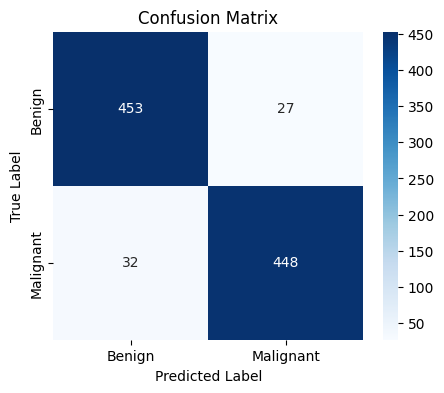

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss")
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    # probability or decision score for ROC-AUC
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        y_prob = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, f1, roc])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score", "ROC-AUC"])
df_results.sort_values(by="Accuracy", ascending=False, inplace=True)
df_results


,Model,Accuracy,F1 Score,ROC-AUC
1,SVM (Linear),0.938542,0.938220,0.987687
0,Logistic Regression,0.932292,0.931507,0.987300
3,KNN,0.923958,0.923400,0.967899
5,XGBoost,0.916667,0.916318,0.976085
2,Random Forest,0.891667,0.892784,0.956224
4,Naive Bayes,0.844792,0.850851,0.908592


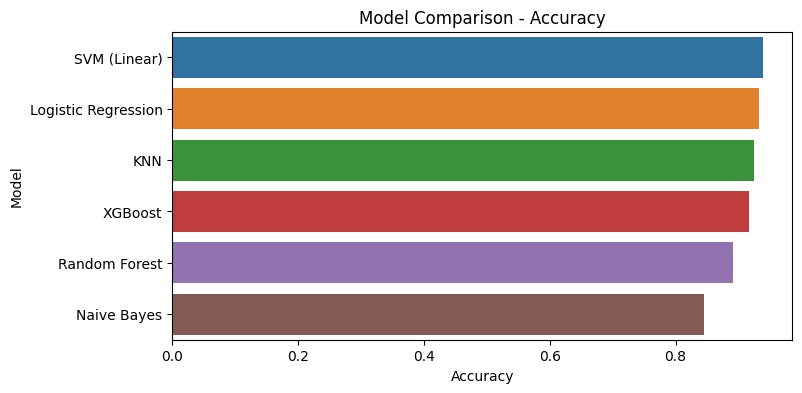

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(data=df_results, x="Accuracy", y="Model")
plt.title("Model Comparison - Accuracy")
plt.show()
